In [1]:
import src.backtest_utils as sbtu
import pickle
import pandas as pd

In [2]:
_data_loader = sbtu.DataLoader.init_from_paths('other.json', 'base.json')
_strategy_path = _data_loader.file_path('strategy_lookup.pkl')
with open(_strategy_path, 'rb') as f:
    _strategy_lookup = pickle.load(f)

_entry_path = _data_loader.file_path('entry_table_15m.pkl')
with open(_entry_path, 'rb') as f:
    _entry_table = pickle.load(f)

_peak_path = _data_loader.file_path('peak_table_15m.pkl')
with open(_peak_path, 'rb') as f:
    _peak_table = pickle.load(f)

_bench_str = 'SPY'
_interval = '15m'
_price_data = pd.read_csv(_data_loader.history_path(_bench_str, _interval), index_col=0, header=[0,1]).iloc[1:].astype('float64')
_price_data.index = pd.to_datetime(_price_data.index, utc=True)
_bench = pd.read_csv(_data_loader.bench_path(_bench_str, _interval), index_col=0).astype('float64')
_bench.index = pd.to_datetime(_bench.index, utc=True)
_relative_rebased = sbtu.PriceGlob(_price_data).relative_rebased(_bench.close)
_strategy_overview = pd.read_csv(_data_loader.file_path('stat_overview_15m.csv'))

_price_data_by_symbol = sbtu.PriceGlob(_price_data).swap_level()

<AxesSubplot:>

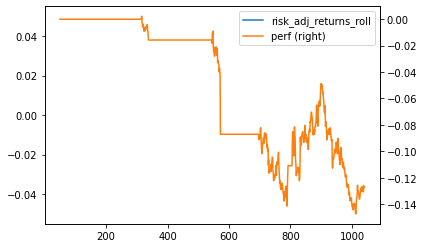

In [3]:
symbol = 'STX'
_strat_data = _strategy_lookup[symbol]
_stats = _strategy_lookup[symbol].stat_historical

_stats[['risk_adj_returns_roll', 'perf']].plot(use_index=False, secondary_y=['perf'])


<AxesSubplot:>

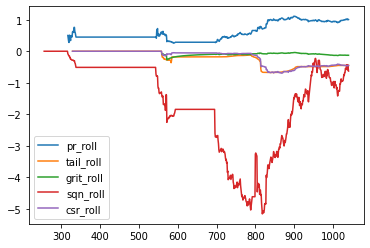

In [4]:
plot_copy = _stats[['pr_roll', 'tail_roll', 'grit_roll', 'sqn_roll', 'csr_roll']]
plot_copy.plot(use_index=False)

<AxesSubplot:title={'center':'STX'}>

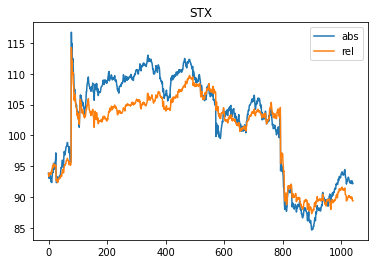

In [5]:
# base = 90
# for i in range(10):
#     quick_plot(base+i)
import src.utils.regime as sur
_symbol_data = _price_data_by_symbol.data[symbol]
_relative = sur.simple_relative(_symbol_data, _bench.close).close
_abs_rel_close = pd.DataFrame(
    data={
        'abs': _symbol_data.close,
        'rel': _relative
    }
)
_abs_rel_close.plot(title=symbol, use_index=False)

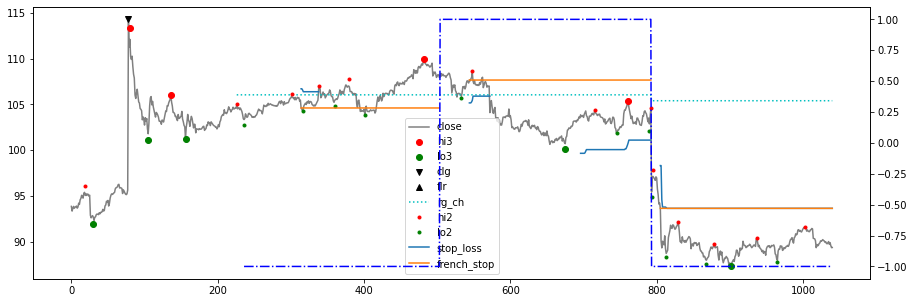

In [6]:
import src.scanner as scanner

epd = _strategy_lookup[symbol].enhanced_price_data.copy()
epd['french_stop'] = _strategy_lookup[symbol].french_stop.stop_price
_sl = _strategy_lookup[symbol].stop_loss_series
_sl = _sl.loc[~_sl.index.duplicated(keep='first')]
epd['stop_loss'] = _sl
# epd['base_close'] = _symbol_data.close
scanner.enhanced_price_data_plot(epd)

In [7]:
# _sd = _symbol_data.copy()
# _sd['french_stop'] = _strategy_lookup[symbol].french_stop.stop_price * (_bench.close/_bench.close.iloc[0])
# _sd['stop_loss'] = _strategy_lookup[symbol].stop_loss_series * (_bench.close/_bench.close.iloc[0])
# _sd[['close', 'french_stop', 'stop_loss']].plot(use_index=False, figsize=(15, 5))

In [8]:
# scanner.rolling_plot(
#     _symbol_data,
#     epd,
#     stop_loss_t=_strategy_lookup[symbol].stop_loss_series,
#     ticker=symbol
# )
import src.utils.pd_accessors as pda
import numpy as np
_pt = _strategy_lookup[symbol].peak_table.copy()

_pt['px'] = np.where(
    _pt.type == 1,
    epd.low.loc[_pt.start],
    epd.high.loc[_pt.start],
)
_pt = pda.PeakTable(_pt)
_pt = _pt.unpivot('15T', _symbol_data.index)
_pt = _pt.loc[~_pt.index.duplicated(keep='first')]
_shi_px = _pt.loc[(_pt.type == -1)]
_shi_1 = _shi_px.loc[(_shi_px.lvl == 1), 'px']
_shi_2 = _shi_px.loc[(_shi_px.lvl == 2), 'px']
_shi_3 = _shi_px.loc[(_shi_px.lvl == 3), 'px']

_slo_px = _pt.loc[(_pt.type == 1)]
_slo_1 = _slo_px.loc[(_slo_px.lvl == 1), 'px']
_slo_2 = _slo_px.loc[(_slo_px.lvl == 2), 'px']
_slo_3 = _slo_px.loc[(_slo_px.lvl == 3), 'px']



<AxesSubplot:>

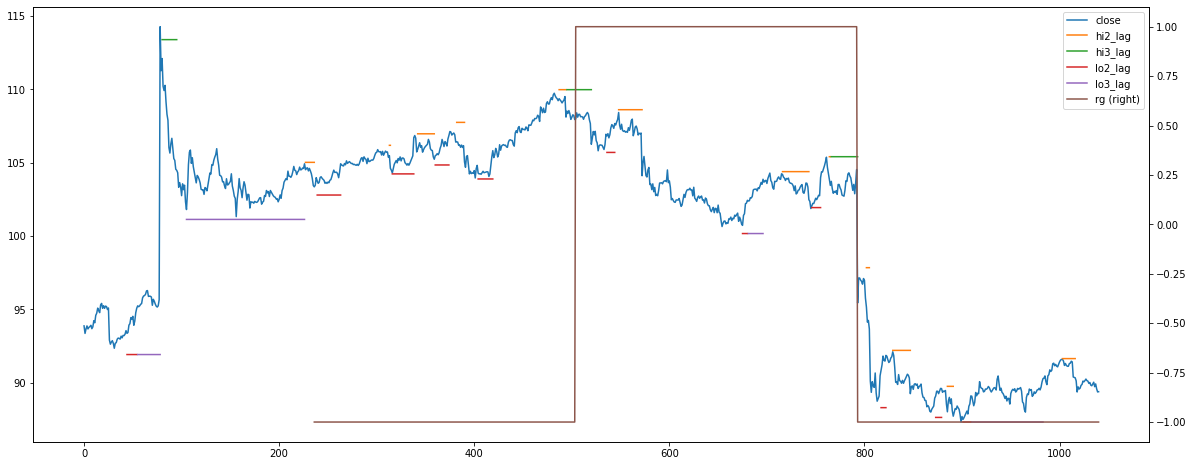

In [9]:
epd['hi1_lag'] = _shi_1
epd['hi2_lag'] = _shi_2
epd['hi3_lag'] = _shi_3
epd['lo1_lag'] = _slo_1
epd['lo2_lag'] = _slo_2
epd['lo3_lag'] = _slo_3

epd[
    ['close', 'hi2_lag', 'hi3_lag', 'lo2_lag', 'lo3_lag', 'rg']
].plot(use_index=False, figsize=(20, 8), secondary_y='rg')

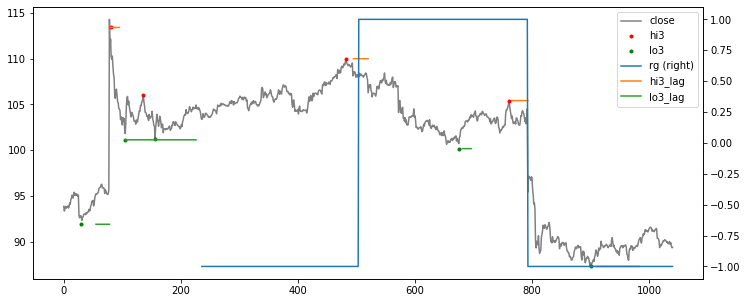

In [10]:
import src.utils.regime as regime
import matplotlib.pyplot as plt

_epd_plt = epd[['close', 'hi2', 'lo2', 'hi3', 'lo3', 'rg']]

def plot(lvl):
    epd[['close', f'hi{lvl}', f'lo{lvl}', 'rg', f'hi{lvl}_lag', f'lo{lvl}_lag']].plot(style=['grey', 'r.', 'g.'], use_index=False, figsize=[12, 5], secondary_y='rg')

plot(3)

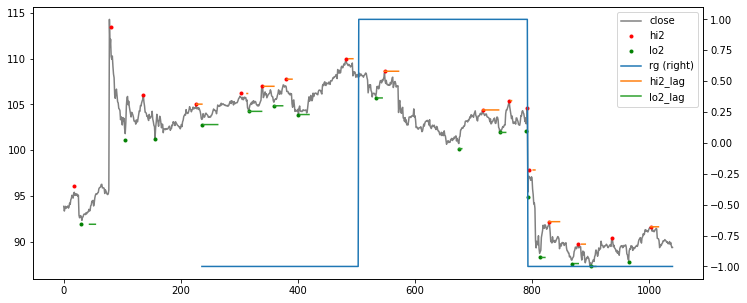

In [11]:
plot(2)

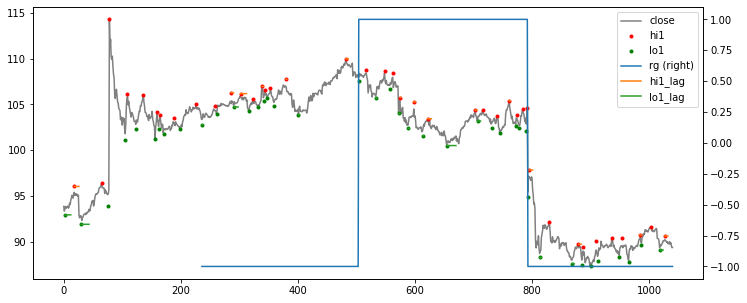

In [12]:
plot(1)

<AxesSubplot:ylabel='Frequency'>

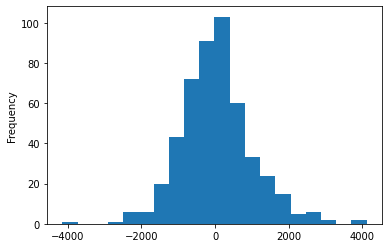

In [13]:
_strategy_overview.weight_total.plot.hist(bins=20)

<AxesSubplot:ylabel='Frequency'>

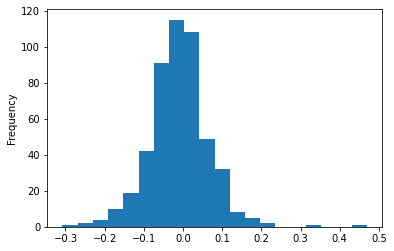

In [14]:
_strategy_overview.perf.plot.hist(bins=20)

In [15]:
def assign_start_end_id(start_end_table, price_table, start_col, end_col):
    merge_start = (
        price_table
        .reset_index()[['Datetime']]
        .reset_index()
        .rename(columns={'Datetime': start_col, 'index': f'{start_col}_id'})
    )
    merge_end = merge_start.rename(columns={start_col: end_col, f'{start_col}_id': f'{end_col}_id'})
    start_end_table = start_end_table.merge(merge_start, on=start_col)
    start_end_table = start_end_table.merge(merge_end, on=end_col)
    return start_end_table, merge_start

_entry_table, _sd_entry = assign_start_end_id(_entry_table, _symbol_data, 'entry', 'exit_signal_date')

_sd_partial = _sd_entry.rename(columns={'entry': 'partial_exit_date', 'entry_id': 'partial_id'})
_entry_table.partial_exit_date = _entry_table.partial_exit_date.fillna(pd.Timestamp(0, tz='UTC'))
_entry_table = _entry_table.merge(_sd_partial, on='partial_exit_date', how='left')
_entry_table.loc[_entry_table.partial_exit_date == pd.Timestamp(0, tz='UTC'), 'partial_exit_date'] = np.nan


In [16]:
_peak_table, _ = assign_start_end_id(_peak_table, _symbol_data, 'start', 'end')

In [17]:
_peak_table['peak_lag'] = _peak_table.end_id - _peak_table.start_id
partial_exit_lag = _entry_table.partial_id - _entry_table.entry_id

<AxesSubplot:ylabel='Frequency'>

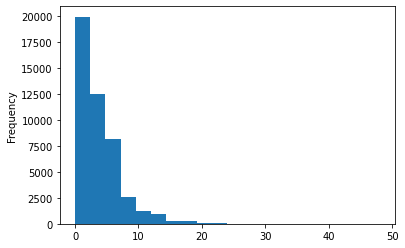

In [18]:
_peak_table.loc[_peak_table.lvl == 1, 'peak_lag'].plot.hist(bins=20)

<AxesSubplot:ylabel='Frequency'>

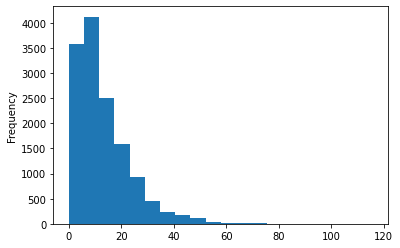

In [19]:
_peak_table.loc[_peak_table.lvl == 2, 'peak_lag'].plot.hist(bins=20)

<AxesSubplot:ylabel='Frequency'>

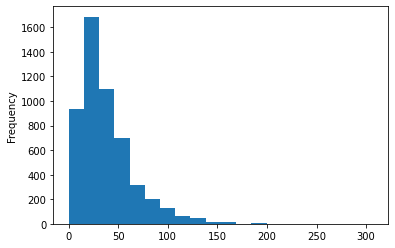

In [20]:
_peak_table.loc[_peak_table.lvl == 3, 'peak_lag'].plot.hist(bins=20)

In [21]:
_peak_table.loc[(_peak_table.lvl == 3) & (_peak_table.peak_lag > 200)]

,start,end,type,lvl,st_px,en_px,symbol,start_id,end_id,peak_lag
33762,2022-02-09 15:15:00+00:00,2022-02-25 20:30:00+00:00,-1,3,66.172662,64.454305,JCI,315,622,307


In [37]:
# peak_price + (-0.005 * peak_price * entry_dir)
stop_mod = _entry_table.st_px + (_entry_table.st_px * 0.005 * _entry_table.dir * -1)
_entry_table['r'] = (_entry_table.en_px - stop_mod ) * _entry_table.dir
# _entry_table.r.plot.hist(bins=20)
_entry_table.loc[_entry_table.r < 0]
print('partial exit reached pct: ', _entry_table.partial_exit_date.count() / len(_entry_table.partial_exit_date))

partial exit reached pct:  0.23240072202166065


<AxesSubplot:ylabel='Frequency'>

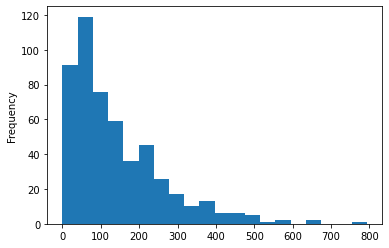

In [35]:
(_entry_table.partial_id - _entry_table.entry_id).plot.hist(bins=20)